In [ ]:
!pip install --upgrade scikit-image

In [ ]:
!pip install optuna-integration[xgboost]

In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from skimage.feature import hog
from optuna.integration import XGBoostPruningCallback
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
from joblib import Parallel, delayed
import pickle
import gc


In [ ]:
# Paths for images and masks
covid_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/COVID19_xrays"
noncovid_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/NonCOVID19_xrays"
normal_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/Normal_xrays"

covid_mask_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_COVID19"
noncovid_mask_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_NonCOVID"
normal_mask_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_Normal"


In [ ]:
# Count the number of files in each path
#paths = [covid_path, noncovid_path, normal_path, covid_mask_path, #noncovid_mask_path, normal_mask_path]
#labels = ['COVID X-rays', 'Non-COVID X-rays', 'Normal X-rays', 'COVID Masks', #'Non-COVID Masks', 'Normal Masks']

#counts = [[label, len(os.listdir(path))] for label, path in zip(labels, paths)]
#counts_df = pd.DataFrame(counts, columns=['Path', 'File Count'])
#print(counts_df)

               Path  File Count
0      COVID X-rays       11956
1  Non-COVID X-rays       11263
2     Normal X-rays       10701
3       COVID Masks       11956
4   Non-COVID Masks       11263
5      Normal Masks       10701


In [ ]:
# Function to load and preprocess images in batches
def load_and_preprocess_batch(image_paths, mask_paths, label):
    images, labels = [], []
    for img_path, mask_path in zip(image_paths, mask_paths):
        # Load the image and corresponding mask
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Check if the image and mask are loaded properly
        if img is None or mask is None:
            continue

        # Resize image and mask to 256x256
        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        # Apply mask to the image (bitwise_and)
        img = cv2.bitwise_and(img, mask)

        # Normalize the image
        img = img / 255.0

        # HOG feature extraction
        features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)
        images.append(features)
        labels.append(label)

    return images, labels

In [ ]:
# Function to load images and preprocess them in parallel in batches
def load_and_preprocess_images(image_path, mask_path, label, batch_size=50):
    img_names = os.listdir(image_path)
    mask_names = os.listdir(mask_path)

    # Sort image and mask names to ensure they match
    img_names.sort()
    mask_names.sort()

    # Split image and mask names into batches
    batches = [(img_names[i:i + batch_size], mask_names[i:i + batch_size]) for i in range(0, len(img_names), batch_size)]

    images, labels = [], []
    for img_batch, mask_batch in batches:
        img_paths = [os.path.join(image_path, img_name) for img_name in img_batch]
        mask_paths = [os.path.join(mask_path, mask_name) for mask_name in mask_batch]
        batch_images, batch_labels = load_and_preprocess_batch(img_paths, mask_paths, label)
        images.extend(batch_images)
        labels.extend(batch_labels)

        # Collect garbage to free memory
        gc.collect()

    return images, labels

In [ ]:
# Load and preprocess data in batches
covid_images, covid_labels = load_and_preprocess_images(covid_path, covid_mask_path, label='COVID')
noncovid_images, noncovid_labels = load_and_preprocess_images(noncovid_path, noncovid_mask_path, label='Non-COVID')
normal_images, normal_labels = load_and_preprocess_images(normal_path, normal_mask_path, label='Normal')

# Combine the data
X = np.array(covid_images + noncovid_images + normal_images)
y = np.array(covid_labels + noncovid_labels + normal_labels)

# Encode labels
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(y)

# Save preprocessed data to disk
with open('preprocessed_data.pkl', 'wb') as f:
    pickle.dump((X, y), f)

In [ ]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Save checkpoint after splitting and scaling data
with open('checkpoint_train_val_test_split.pkl', 'wb') as f:
    pickle.dump((X_train, X_val, X_test, y_train, y_val, y_test), f)


In [ ]:
# Define parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2],
    'colsample_bytree': [0.8, 1]
}


In [ ]:
# Train XGBoost model using Optuna for hyperparameter tuning
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, step=0.01),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 2),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        'objective': 'multi:softmax',
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'n_jobs': -1  # Use all available CPU cores for training
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mlogloss', verbose=False)

    val_predictions = model.predict(X_val)
    val_accuracy = np.mean(val_predictions == y_val)
    return val_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)

# Save study checkpoint after all trials are done
with open('optuna_study_checkpoint.pkl', 'wb') as f:
    pickle.dump(study, f)

[I 2024-10-28 16:38:27,645] A new study created in memory with name: no-name-d988164a-0aaa-418f-bb7a-efcfffb28ad9
[I 2024-10-28 17:40:42,167] Trial 0 finished with value: 0.6835691823899371 and parameters: {'n_estimators': 200, 'learning_rate': 0.03, 'max_depth': 6, 'subsample': 0.8321876910476343, 'reg_alpha': 0.47181099729434695, 'reg_lambda': 1.7510049828316365, 'colsample_bytree': 0.9964574412383155}. Best is trial 0 with value: 0.6835691823899371.


In [ ]:
# Load preprocessed data
with open('/content/preprocessed_data.pkl', 'rb') as f:
    X, y = pickle.load(f)

# Load train, validation, and test sets
with open('/content/checkpoint_train_val_test_split.pkl', 'rb') as f:
    X_train, X_val, X_test, y_train, y_val, y_test = pickle.load(f)

# Load Optuna study checkpoint
with open('/content/optuna_study_checkpoint.pkl', 'rb') as f:
    study = pickle.load(f)

In [ ]:
# Train final model with best parameters
best_params = study.best_params
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mlogloss', verbose=False)

# Save final model checkpoint
with open('final_model_checkpoint.pkl', 'wb') as f:
    pickle.dump(final_model, f)

In [14]:
# Encode labels
y_encoder = LabelEncoder()
y_encoder.fit(['COVID', 'Non-COVID', 'Normal'])

LabelEncoder()

In [15]:
# Evaluate on validation set
y_val_pred = final_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')
print('Validation Classification Report:')
print(classification_report(y_val, y_val_pred, target_names=y_encoder.classes_))

# Evaluate on test set
y_test_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print('Test Classification Report:')
print(classification_report(y_test, y_test_pred, target_names=y_encoder.classes_))


Validation Accuracy: 68.36%
Validation Classification Report:
              precision    recall  f1-score   support

       COVID       0.63      0.75      0.69      1807
   Non-COVID       0.76      0.57      0.65      1660
      Normal       0.69      0.73      0.71      1621

    accuracy                           0.68      5088
   macro avg       0.69      0.68      0.68      5088
weighted avg       0.69      0.68      0.68      5088

Test Accuracy: 67.77%
Test Classification Report:
              precision    recall  f1-score   support

       COVID       0.62      0.74      0.67      1770
   Non-COVID       0.74      0.54      0.62      1680
      Normal       0.71      0.75      0.73      1638

    accuracy                           0.68      5088
   macro avg       0.69      0.68      0.68      5088
weighted avg       0.69      0.68      0.67      5088



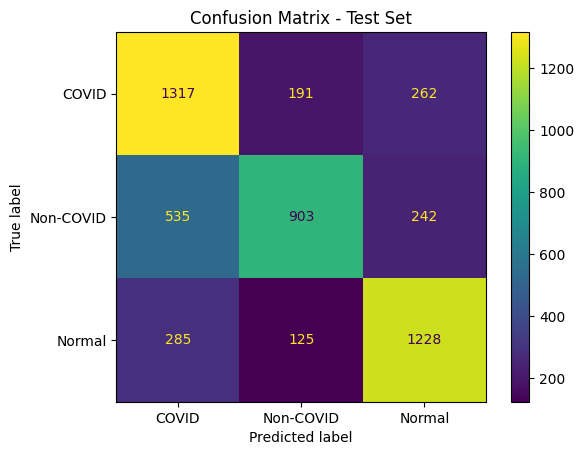

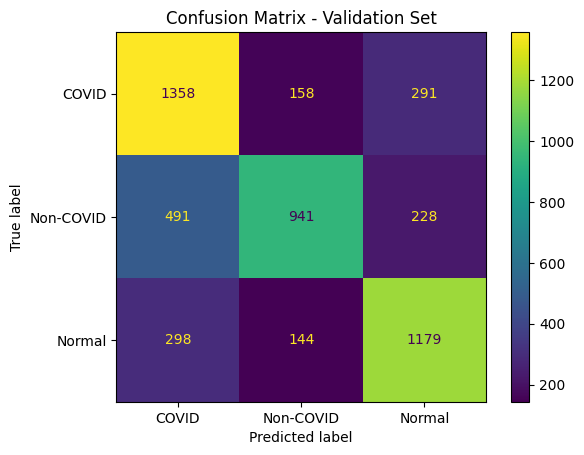

In [17]:
# Plot confusion matrix for test set
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['COVID', 'Non-COVID', 'Normal'])
disp.plot()
plt.title('Confusion Matrix - Test Set')
plt.show()

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=y_encoder.classes_)
disp_val.plot()
plt.title('Confusion Matrix - Validation Set')
plt.show()


In [19]:
# Plot validation and training convergence
results = final_model.evals_result()
plt.plot(results['validation_0']['mlogloss'], label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Training Convergence')
plt.legend()
plt.show()

XGBoostError: No evaluation result, `eval_set` is not used during training.